In [1]:
from data import get_adata
from data import test
import scanpy as sc
import numpy as np


/home/user/anaconda3/envs/INVAE/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
anndata = sc.read('dataset/kang_normalized.h5ad')
anndata
#np.unique(anndata.obs['cell_type'])

AnnData object with n_obs × n_vars = 13576 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'stim', 'seurat_annotations', 'integrated_snn_res.0.5', 'seurat_clusters', 'condition', 'cell_type', 'n_counts'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg'

In [3]:
print(np.unique(anndata.obs['cell_type']))
print(np.unique(anndata.obs['condition']))

['B' 'CD14 Mono' 'CD16 Mono' 'CD4 T' 'CD8 T' 'DC' 'NK' 'T']
['control' 'stimulated']


In [4]:
path = 'dataset/kang_normalized.h5ad'
p_cell = 'CD14 Mono'
t_cond = 'stimulated'
p_cond = 'control'
cell_t_key = 'cell_type'
cond_t_key = 'condition'

In [6]:
from INVAE import INVAE
from INVAE import main
from model import *
from utils import *

In [7]:
#get the true predicted data for evaluate
adata, pred_cell_N, targ_cond_N, pred_cond_N = get_adata(anndata_path = path, pred_cell = p_cell, targ_condition = p_cond, pred_condition=t_cond ,cell_type_key=cell_t_key, condition_type_key=cond_t_key)
adata = adata[adata[:,-2]==pred_cell_N]
fea_n = adata.shape[1] - 2
adata = adata[:,:fea_n]
real_mean_ = np.mean(adata.numpy(), axis=0)

In [8]:
#train model

model = main(ann_path=path, pred_cell=p_cell, targ_condition=t_cond, pred_condition=p_cond,epoch_N=500, bat_N=512,cell_type_key=cell_t_key, condition_type_key=cond_t_key,real_mean_=real_mean_)

===============eva==========================
r-squared: 0.5904038001510628

===============eva==========================
r-squared: 0.7668770717752721

===============eva==========================
r-squared: 0.8019444785540006

===============eva==========================
r-squared: 0.8258365871008218

===============eva==========================
r-squared: 0.8492499367420996

===============eva==========================
r-squared: 0.8723014663053736

===============eva==========================
r-squared: 0.882446009419723

===============eva==========================
r-squared: 0.8744808807696369

===============eva==========================
r-squared: 0.8741858036401167

===============eva==========================
r-squared: 0.8836488573953079

===============eva==========================
r-squared: 0.9074376742351385

===============eva==========================
r-squared: 0.8906602946223108

===============eva==========================
r-squared: 0.9141884138264075

=============

In [10]:
#save the generated data
adata, pred_cell_N, targ_cond_N, pred_cond_N = get_adata(anndata_path = path, pred_cell = p_cell, targ_condition = t_cond, pred_condition=p_cond,cell_type_key=cell_t_key, condition_type_key=cond_t_key)
adata = adata[adata[:,-2]==pred_cell_N]
z_params_o = model.encoder.forward(adata.cuda()).view(adata.size(0), (60), 2)
z_params_o = torch.clamp(z_params_o, min=-30,max=30)
z_params = Normal().sample(params=z_params_o).cuda()


z_com = z_params[:,:(30)]
z_spe = z_params[:,(30):(60)]
impute_D = adata[:,-1].reshape([-1,1]).cuda() 
impute_D[:] = targ_cond_N
impute_C = adata[:,-2].reshape([-1,1]).cuda()

inp_spe = torch.cat((z_spe,impute_D),1)
inp_con = torch.cat((z_com,impute_C),1)

z_proj_N = model.p_layer.forward(inp_spe)
x_params_spe_N = model.decoder_S.forward(z_proj_N)
x_params_spe_N = x_params_spe_N.view(len(inp_con), fea_n)
x_params_com_N = model.decoder_C.forward(inp_con).view(len(inp_con), fea_n)
x_params_N = x_params_spe_N + x_params_com_N 

outfile = 'output/pred_' + p_cell 
np.save(outfile, x_params_N.detach().cpu().numpy())

In [11]:
#visualization

In [12]:
adata, pred_cell_indx, pred_condition_indx = get_adata(anndata_path = path, pred_cell = p_cell, targ_condition = t_cond, pred_condition=p_cond ,cell_type_key=cell_t_key, condition_type_key=cond_t_key, isevalu=True)

In [13]:
x_params_spe_N = np.zeros([adata.shape[0],adata.shape[1]-2])
x_params_com_N = np.zeros([adata.shape[0],adata.shape[1]-2])
for i in range(len(adata)//1000 + 1):
    x = adata[(i*1000):((i+1)*1000)]
    z_params_o = model.encoder.forward(x.cuda()).view(x.size(0), (60), 2)
    
    
    z_params_o = torch.clamp(z_params_o, min=-30,max=30)
    z_params = Normal().sample(params=z_params_o).cuda()

    z_com = z_params[:,:(30)]
    z_spe = z_params[:,(30):(60)]
    impute_D = x[:,-1].reshape([-1,1]).cuda() 
    impute_C = x[:,-2].reshape([-1,1]).cuda()
    inp_spe = torch.cat((z_spe,impute_D),1)
    inp_con = torch.cat((z_com,impute_C),1)
    
    
    z_proj_N = model.p_layer.forward(inp_spe)
    sav_spe_N = model.decoder_S.forward(z_proj_N)
    sav_con_N = model.decoder_C.forward(inp_con)
    x_params_spe_N[(i*1000):((i+1)*1000)] = sav_spe_N.view(len(inp_spe), fea_n).cpu().detach().numpy()
    x_params_com_N[(i*1000):((i+1)*1000)] = sav_con_N.view(len(inp_spe), fea_n).cpu().detach().numpy()

In [14]:
load_matrix_LA_ = []
for i in adata[:,-2]:
    load_matrix_LA_.append(pred_cell_indx[int(i.item())])
    #print(i)

load_matrix_LA_D_ = []
for i in adata[:,-1]:
    load_matrix_LA_D_.append(pred_condition_indx[int(i.item())])

In [15]:
import anndata
N_data = anndata.AnnData(X=x_params_spe_N)   #x_params_com_N for condition-invariance output
N_data.obs['cell_type'] = np.array(load_matrix_LA_)
N_data.obs['condition'] = np.array(load_matrix_LA_D_)
N_data

AnnData object with n_obs × n_vars = 13576 × 2000
    obs: 'cell_type', 'condition'

         Falling back to preprocessing with `sc.pp.pca` and default params.
... storing 'cell_type' as categorical
... storing 'condition' as categorical


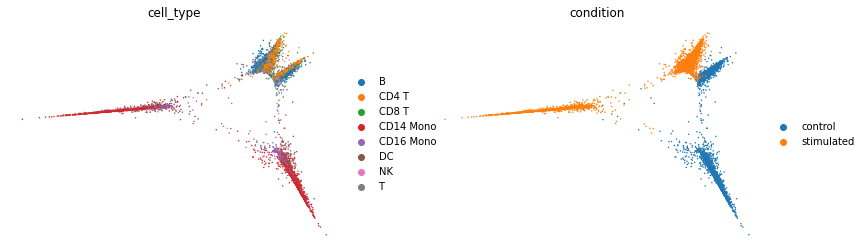

In [16]:

import matplotlib 
import scanpy as sc

sc.pp.neighbors(N_data)
sc.tl.umap(N_data)
sc.pl.umap(N_data, color=['cell_type','condition'],
           show=True,
           wspace=0.15,
           frameon=False)